In [1]:
import os, importlib, sys, time, h5py

In [7]:
import numpy as np
from scipy import io, linalg, stats, ndimage
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':10})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ldfa.ldfa as ldfa

# load data and EDA

In [13]:
data_dir = "../data/"
file_name = ['v4_lfp_bred.mat', 'pfc_lfp_bred.mat']
rec_time = [0, 0.5]

In [14]:
data = [h5py.File('%s/%s'%(data_dir, fname))\
        .get('lfp_bred').value[:,:,::2]
        for fname in file_name]

/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
data[0].shape, data[1].shape

((101, 24, 500), (101, 25, 500))

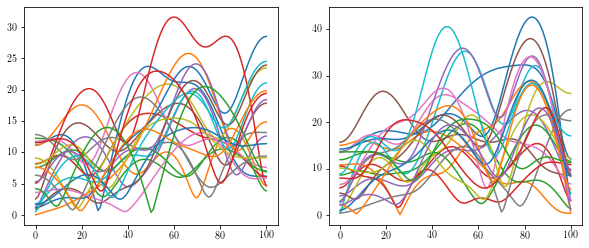

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][:,:,0])
plt.subplot(1,2,2); plt.plot(data[1][:,:,0])
plt.show()

# tuning parameters
## preset parameters from EDA

In [17]:
offset_cross=5; offset_auto=5
lambda_auto = 0.0

## cross-validation

In [ ]:
# candidate parameters
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1]
num_factors = [5,10, 15, 20, 25, 30, 35, 40]

In [ ]:
# CV takes long, we skip it here
# AICs = np.zeros(len(num_factors))
# BICs = np.zeros(len(num_factors))
# for fi in range(len(num_factors)):
#     num_f = num_factors[fi]
#     loglikes = cross_validate(data, num_f, lambdas)
#     maxi = np.argmax(loglikes)
#     lambda_cross = lambdas[maxi]
#     print(num_f, ' factors CV results: ', loglikes)
#     print('picking: ', lambda_cross)
#     Pi, Rho, params = ldfa.est(
#         data, num_f, lambda_cross, offset_cross, lambda_auto, offset_auto,
#         make_pd=True)
#     AICs[fi] = ldfa.AIC(data, params)
#     BICs[fi] = ldfa.BIC(data, params)

In [ ]:
# CV result
lambda_cross = 0.001
num_f = 10

## estimate

In [ ]:
Pi, Rho, params = ldfa.fit(
    data, num_f, lambda_cross, offset_cross, lambda_auto, offset_auto,
    make_PD=True)

# result

In [ ]:
Sigma0 = np.linalg.inv(params['Omega'])

Text(0, 0.5, '$ \\Vert \\Sigma_f \\Vert_F^2 $')

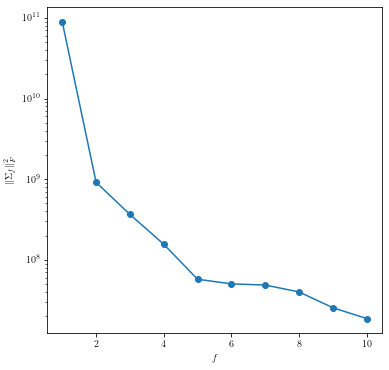

In [6]:
# figure showing amplitude for each factor characterized by Frobenius Norm
amplitude = np.sum(Sigma0**2, (-1, -2)) 

plt.figure(figsize=(6,6))
plt.semilogy(np.arange(num_f)+1,amplitude)
plt.scatter(np.arange(num_f)+1,amplitude)  
plt.xlabel(r'$f$')
plt.ylabel(r'$ \Vert \Sigma_f \Vert_F^2 $')

Text(0, 0.5, 'Amplitude')

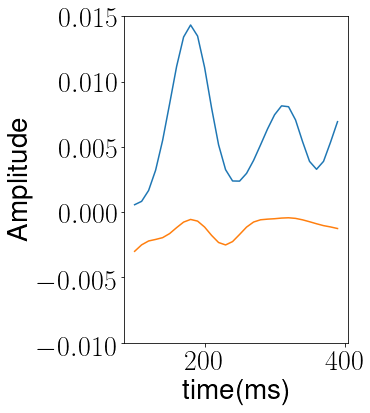

In [7]:
# figure showing information flow in the main body
from scipy import ndimage
f = 0 #pick which factor you want to check
s0_switch = Sigma0[f,:,:]
sig = np.sqrt(np.diag(s0_switch))
pi0_org = np.linalg.inv(s0_switch/sig/sig[:,None])
lead_lag = np.zeros(num_time)
lead_lag2 = np.zeros(num_time)
times = np.arange(num_time)
cross = pi0_org[:num_time, num_time:]
for i in range(num_time):
    lead_lag[i] = np.mean((times-i>0)*np.abs(cross[i,:]))
    lead_lag2[i] = np.mean((times-i<0)*np.abs(cross[i,:]))

# smooth the result
sigma = 2
x_g1d = ndimage.gaussian_filter1d(times, sigma)
y_g1d = ndimage.gaussian_filter1d(lead_lag, sigma)
y_g1d2 = ndimage.gaussian_filter1d(lead_lag2, sigma)

# plot
plt.figure(figsize=(4,6))
plt.rcParams.update({'font.size': 28})
plt.plot(x_g1d[10:40]*10,y_g1d[10:40])
plt.plot(x_g1d[10:40]*10,-y_g1d2[10:40])
plt.ylim([-0.01,0.015])
#plt.legend(['V4-PFC', 'PFC-V4'])
plt.xlabel('time(ms)')
plt.ylabel('Amplitude')

(100.0, 480.0)

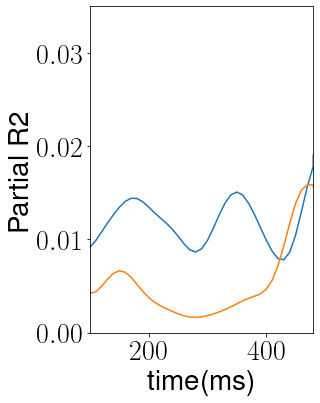

In [8]:
# figure showing information flow by partial R^2 in the appendix
from scipy import ndimage
f = 3 # pick which factor you want to check
bt = 1 #pick which time you like to start calculation
s0 = Sigma0[f,:,:]
ss1 = np.ones(num_time)
ss2 = np.ones(num_time)
pss1 = np.ones(num_time)
pss2 = np.ones(num_time)
times = np.arange(num_time)
cross = s0[:num_time, num_time:]
for i in range(bt, num_time):
    Syy1 = s0[i,i]
    Syy2 = s0[i+num_time, i+num_time]
    sxx = []
    inds = np.array([h for h in range(i)] + [h+num_time for h in range(i)])
    for ii in inds:
        for jj in inds:
            sxx.append(s0[jj,ii])
    Sxx = np.array(sxx).reshape((len(inds), len(inds)))
    Sxy1 = s0[inds,i][:,None]
    Sxy2 = s0[inds,i+num_time][:,None]
    ss1[i] = Syy1 - Sxy1.transpose((1,0))@np.linalg.inv(Sxx)@Sxy1
    ss2[i] = Syy2 - Sxy2.transpose((1,0))@np.linalg.inv(Sxx)@Sxy2
    
    #now only consider inside
    pSxx1 = s0[:i, :i]
    pSxx2 = s0[num_time:(num_time+i), num_time:(num_time+i)]
    pSxy1 = s0[:i,i][:,None]
    pSxy2 = s0[num_time:(num_time+i),i+nmum_time][:,None]
    pss1[i] = Syy1 - pSxy1.transpose((1,0))@np.linalg.inv(pSxx1)@pSxy1
    pss2[i] = Syy2 - pSxy2.transpose((1,0))@np.linalg.inv(pSxx2)@pSxy2

# smooth the result
sigma = 2.5
lead_lag1 = (pss1-ss1)/pss1
lead_lag2 = (pss2-ss2)/pss2
x_g1d = ndimage.gaussian_filter1d(times, sigma)
y_g1d1 = ndimage.gaussian_filter1d(lead_lag1, sigma)
y_g1d2 = ndimage.gaussian_filter1d(lead_lag2, sigma)

# plot
plt.figure(figsize=(4,6))
plt.rcParams.update({'font.size': 28})
tt = np.arange(bt, num_time, 1)
plt.plot(x_g1d[tt]*10,y_g1d2[tt])
plt.plot(x_g1d[tt]*10,y_g1d1[tt])
#plt.legend(['V4-PFC', 'PFC-V4'])
plt.xlabel('time(ms)')
plt.ylabel('Partial R2')
plt.ylim([0.00,0.035])
plt.xlim([100, 480])